In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


import matplotlib.pyplot as plt 


## 1.Dataset


In [2]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
      root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

C:\Users\duong\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
training_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'We use {device}')

We use cuda


## 2. Initialize Model

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # to convert to 2D image
        self.net = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, X):
        logits = self.net(self.flatten(X))
        return logits


model = NeuralNetwork().to(device)


## 3. Create training/valid function

In [6]:
def training_epoch(model, dataloader, loss_fn, optimizer):
    total_loss, acc = 0,0
    data_size = len(dataloader.dataset)
    for (X,y) in dataloader:
        (X,y) = (X.to(device), y.to(device))
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, y_pred = torch.max(out, dim=1)
        total_loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
    return total_loss/(data_size), acc/(data_size)


In [7]:
def valid_epoch(model, dataloader, loss_fn):
    data_size = len(dataloader.dataset)
    loss, acc = 0,0
    model.eval()
    for X,y in dataloader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        _, y_pred = torch.max(out, dim=1)
        loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
        
    return loss/(data_size), acc/(data_size)


## 4. Select optimizer and loss_function

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

## 5. Train and valid model

In [9]:
train_hist = []
test_hist = []
for t in range(10):
    train_hist.append(training_epoch(model, training_dataloader, loss_fn, optimizer))
    with torch.no_grad():
        test_hist.append(valid_epoch(model, training_dataloader, loss_fn))

In [10]:
train_loss = [i[0] for i in train_hist]
train_acc = [i[1] for i in train_hist]
test_loss = [i[0] for i in test_hist]
test_acc = [i[1] for i in test_hist]


## 6. Visualization loss_avg and accuracy

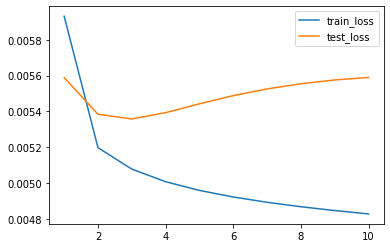

In [11]:

plt.figure()
plt.plot([x+1 for x in range(10)], train_loss)
plt.plot([x+1 for x in range(10)], test_loss)
plt.legend(['train_loss', 'test_loss'])
plt.show()

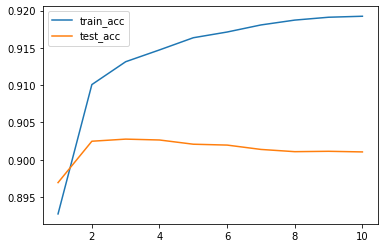

In [12]:
plt.figure()
plt.plot([x+1 for x in range(10)], train_acc)
plt.plot([x+1 for x in range(10)], test_acc)
plt.legend(['train_acc', 'test_acc'])
plt.show()

## 7. Test our model

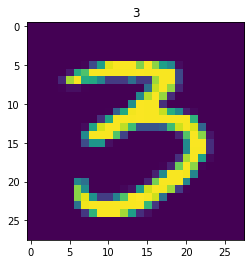

In [22]:
k = torch.randint(0, len(training_data),())

X = training_data[k][0].to(device)
y = torch.tensor(training_data[k][1]).to(device)

def predict(X, model):
    out = model.to(device)(X)
    _,y_pred = torch.max(out, 1)
    return y_pred.item()

def show_img(X, model):
    plt.figure()
    plt.imshow(X.to('cpu').view(28,28))
    plt.title(predict(X, model))
    plt.show()

show_img(X, model)





## 8. Saving model

In [15]:
torch.save(model.state_dict(), 'model/model_state.pth')

## 9. Loading and testing

In [18]:
new_model = NeuralNetwork().to(device)
new_model.load_state_dict(torch.load('model/model_state.pth'))


<All keys matched successfully>

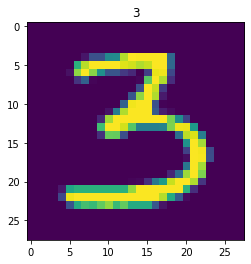

In [19]:
show_img(X, new_model)